Using device: cpu
Files already downloaded and verified
Files already downloaded and verified
[Epoch 1, Batch   200] loss: 1.860
[Epoch 1, Batch   400] loss: 1.549
[Epoch 1, Batch   600] loss: 1.429
Epoch 1:
  Training Accuracy: 53.84%
  Test Accuracy:     52.99%
[Epoch 2, Batch   200] loss: 1.265
[Epoch 2, Batch   400] loss: 1.201
[Epoch 2, Batch   600] loss: 1.165
Epoch 2:
  Training Accuracy: 63.22%
  Test Accuracy:     61.86%
[Epoch 3, Batch   200] loss: 1.053
[Epoch 3, Batch   400] loss: 1.020
[Epoch 3, Batch   600] loss: 0.991
Epoch 3:
  Training Accuracy: 67.83%
  Test Accuracy:     65.70%
Finished Training


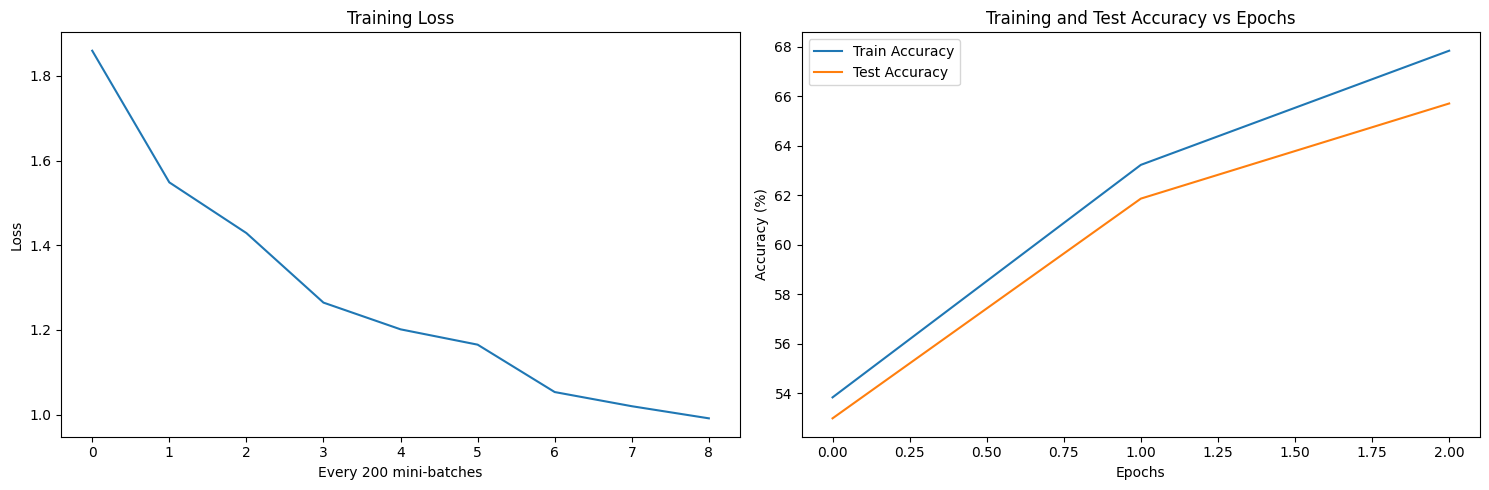

Final Training Accuracy: 67.83%
Final Test Accuracy: 65.70%


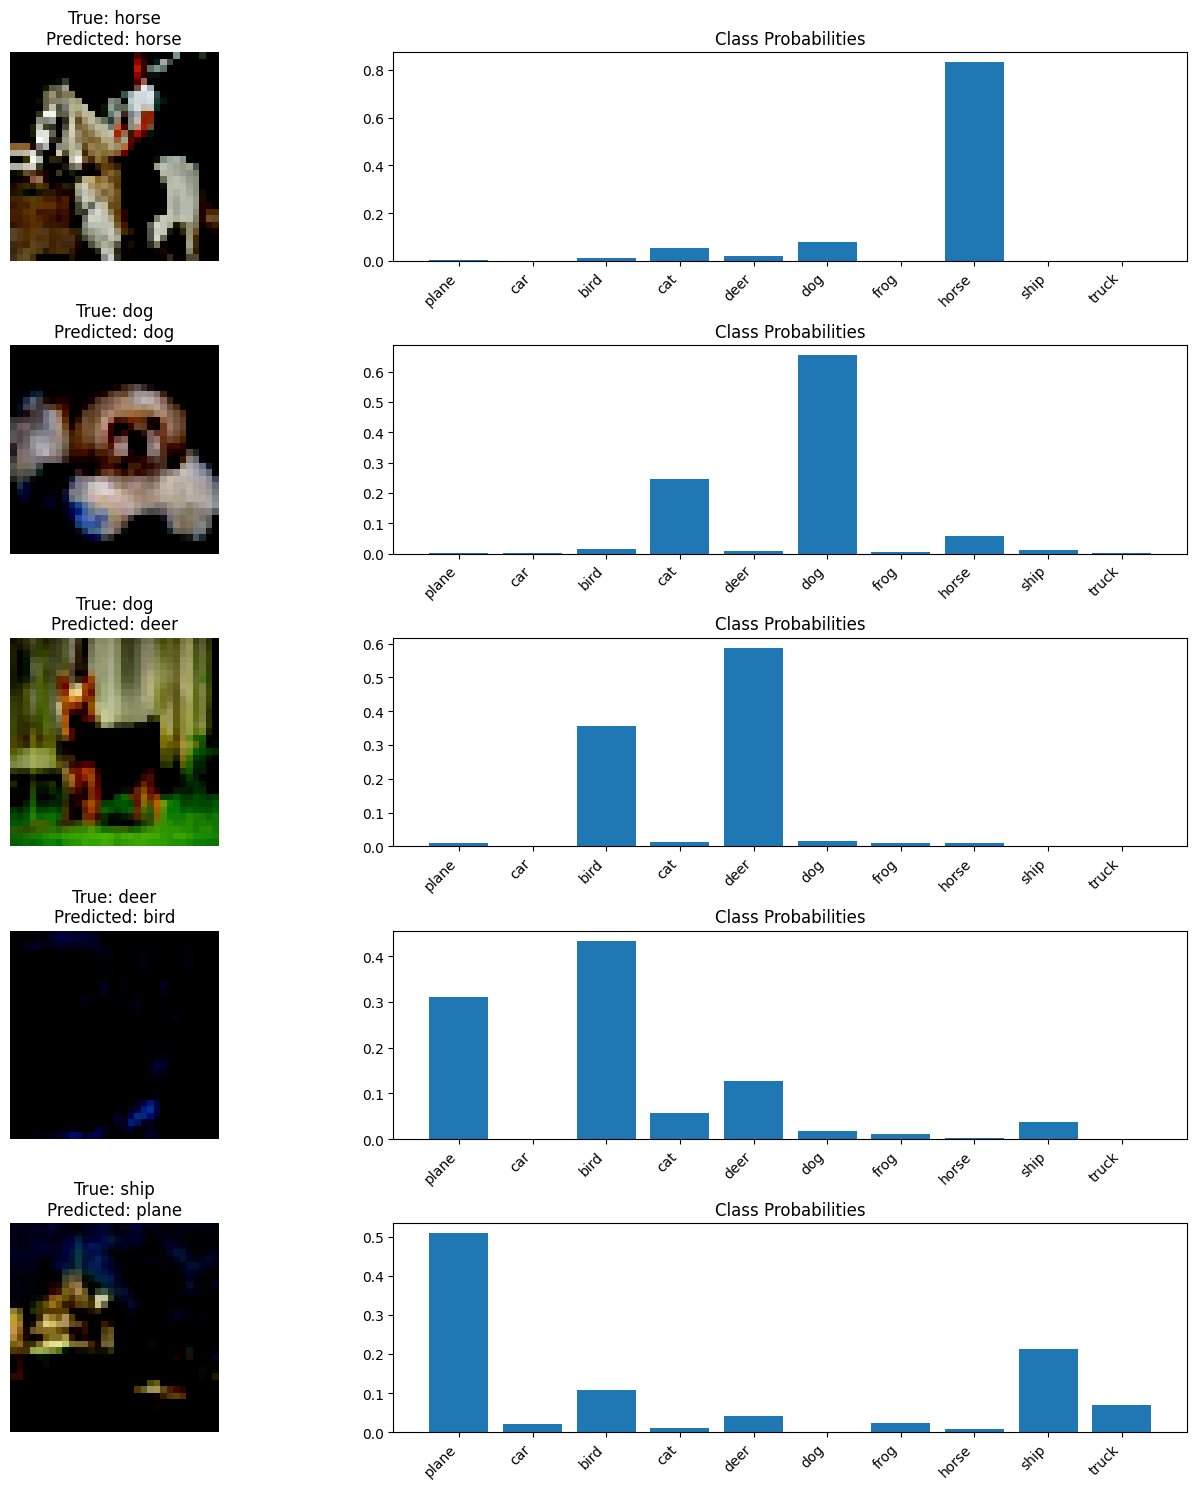

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np

transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3)
        self.conv3 = nn.Conv2d(64, 64, 3)
        self.fc1 = nn.Linear(64 * 4 * 4, 64)
        self.fc2 = nn.Linear(64, 10)

    def forward(self, x):
        x = self.pool(torch.relu(self.conv1(x)))
        x = self.pool(torch.relu(self.conv2(x)))
        x = torch.relu(self.conv3(x))
        x = x.view(-1, 64 * 4 * 4)
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

def calculate_accuracy(loader):
    correct, total = 0, 0
    with torch.no_grad():
        for data in loader:
            images, labels = data[0].to(device), data[1].to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return 100 * correct / total

def train(epochs=10):
    train_losses, train_accuracies, test_accuracies = [], [], []
    for epoch in range(epochs):
        running_loss = 0.0
        for i, data in enumerate(trainloader, 0):
            inputs, labels = data[0].to(device), data[1].to(device)
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            if i % 200 == 199:
                print(f'[Epoch {epoch + 1}, Batch {i + 1:5d}] loss: {running_loss / 200:.3f}')
                train_losses.append(running_loss / 200)
                running_loss = 0.0
        train_accuracy = calculate_accuracy(trainloader)
        test_accuracy = calculate_accuracy(testloader)
        train_accuracies.append(train_accuracy)
        test_accuracies.append(test_accuracy)
        print(f'Epoch {epoch + 1}:')
        print(f'  Training Accuracy: {train_accuracy:.2f}%')
        print(f'  Test Accuracy:     {test_accuracy:.2f}%')
    print('Finished Training')
    return train_losses, train_accuracies, test_accuracies

train_losses, train_accuracies, test_accuracies = train(epochs=3)

plt.figure(figsize=(15, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses)
plt.title('Training Loss')
plt.xlabel('Every 200 mini-batches')
plt.ylabel('Loss')

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(test_accuracies, label='Test Accuracy')
plt.title('Training and Test Accuracy vs Epochs')
plt.xlabel('Epochs')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.tight_layout()
plt.show()

print(f"Final Training Accuracy: {train_accuracies[-1]:.2f}%")
print(f"Final Test Accuracy: {test_accuracies[-1]:.2f}%")

def predict_and_display(num_images=5):
    dataiter = iter(testloader)
    images, labels = next(dataiter)
    sample_indices = np.random.choice(images.shape[0], num_images, replace=False)
    sample_images = images[sample_indices].to(device)
    sample_labels = labels[sample_indices]
    with torch.no_grad():
        outputs = net(sample_images)
        _, predicted = torch.max(outputs, 1)
    plt.figure(figsize=(15, 3 * num_images))
    for i in range(num_images):
        plt.subplot(num_images, 2, 2*i + 1)
        plt.imshow(np.transpose(sample_images[i].cpu().numpy(), (1, 2, 0)))
        plt.title(f"True: {classes[sample_labels[i]]}\nPredicted: {classes[predicted[i]]}")
        plt.axis('off')
        plt.subplot(num_images, 2, 2*i + 2)
        plt.bar(classes, torch.nn.functional.softmax(outputs[i], dim=0).cpu().numpy())
        plt.title("Class Probabilities")
        plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

predict_and_display()
